In [1]:
from vlti_gravity_sim import simulation, visibility, wavefront
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import matplotlib.cm
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import multiprocessing as mp
import h5py
from scipy.signal import fftconvolve
import os
from numpy.fft import ifftshift,fftfreq
from scipy.ndimage import gaussian_filter

/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
def residuals(F, V):
    F4, F3, F2, F1 = F
    V_model = np.array([
        np.sqrt(F4 * F3),
        np.sqrt(F4 * F2),
        np.sqrt(F4 * F1),
        np.sqrt(F3 * F2),
        np.sqrt(F3 * F1),
        np.sqrt(F2 * F1)
    ])
    return V_model - V

# Initial guess
def fit_flux(i, cmcoh_slice):
    F0 = np.ones(4)
    result = least_squares(residuals, F0, args=(cmcoh_slice,), bounds=(0, np.inf))
    F_out = result.x

    return i, F_out

def rotational_kernel(wl, vsini, epsilon=0.0, c=299792.458):
    """
    Create a rotational broadening kernel.
    
    Parameters
    ----------
    wl : array
        Wavelength array in microns (µm).
    vsini : float
        Rotational velocity in km/s.
    epsilon : float
        Linear limb-darkening coefficient.
    c : float
        Speed of light in km/s.

    Returns
    -------
    kernel : array
        Normalized rotational broadening kernel.
    delta_wl : float
        Step size in wavelength.
    """
    # Central wavelength
    wl0 = np.mean(wl)
    
    # Maximum Doppler shift
    delta_lam = wl0 * vsini / c

    # Kernel wavelength grid (±delta_lam)
    N = 500
    dlam = (2 * delta_lam) / N
    x = np.linspace(-1, 1, N)
    
    kernel = np.zeros_like(x)
    idx = np.abs(x) <= 1
    kernel[idx] = (2 * (1 - epsilon) * np.sqrt(1 - x[idx]**2) +
                   np.pi * epsilon / 2 * (1 - x[idx]**2))
    kernel /= (np.pi * (1 - epsilon / 3))  # Normalize area under kernel
    kernel /= np.sum(kernel)              # Ensure kernel sum = 1

    return kernel, dlam

def apply_rotational_broadening(wl, flux, vsini, epsilon=0.0):
    """
    Apply rotational broadening to a spectrum.
    
    Parameters
    ----------
    wl : array
        Wavelength array.
    flux : array
        Flux array.
    vsini : float
        Rotational velocity in km/s.
    epsilon : float
        Limb darkening coefficient.

    Returns
    -------
    flux_broadened : array
        Rotationally broadened flux.
    """
    kernel, dlam = rotational_kernel(wl, vsini, epsilon)
    
    # Interpolate onto a uniform wavelength grid
    wl_uniform = np.arange(wl[0], wl[-1], dlam)
    flux_interp = interp1d(wl, flux, kind='linear', bounds_error=False, fill_value="extrapolate")
    flux_uniform = flux_interp(wl_uniform)

    # Convolve
    broadened = fftconvolve(flux_uniform, kernel, mode='same')

    # Interpolate back to original grid
    flux_broadened = interp1d(wl_uniform, broadened, kind='linear',
                              bounds_error=False, fill_value="extrapolate")(wl)
    
    return flux_broadened

def bin_spectrum(wl_in, flux_in, wl_out):
    """
    Bin a spectrum by integrating flux within the wavelength bins.

    Parameters
    ----------
    wl_in : ndarray
        Original wavelength array (must be sorted and strictly increasing).
    flux_in : ndarray
        Corresponding flux values.
    wl_out : ndarray
        New wavelength bin centers (must be sorted).

    Returns
    -------
    flux_out : ndarray
        Flux values integrated over each bin in wl_out.
    """
    wl_in = np.asarray(wl_in)
    flux_in = np.asarray(flux_in)
    wl_out = np.asarray(wl_out)

    # Define bin edges from bin centers
    wl_edges = np.zeros(len(wl_out) + 1)
    wl_edges[1:-1] = 0.5 * (wl_out[1:] + wl_out[:-1])
    wl_edges[0] = wl_out[0] - (wl_out[1] - wl_out[0]) / 2
    wl_edges[-1] = wl_out[-1] + (wl_out[-1] - wl_out[-2]) / 2

    # Compute cumulative integral
    cum_flux = np.cumsum(np.concatenate([[0], np.diff(wl_in) * (flux_in[:-1] + flux_in[1:]) / 2]))
    cum_flux_interp = np.interp(wl_edges, wl_in, cum_flux, left=0, right=cum_flux[-1])

    # Bin-integrated flux
    flux_binned = np.diff(cum_flux_interp) / np.diff(wl_edges)

    return flux_binned

def doppler_shift(wl, flux, v_rad, c=299792.458):
    """
    Apply a Doppler shift to a spectrum.

    Parameters
    ----------
    wl : array
        Wavelength array in µm.
    flux : array
        Flux array.
    v_rad : float
        Radial velocity in km/s. Positive = redshift.

    Returns
    -------
    flux_shifted : array
        Flux array interpolated onto the original wavelength grid after Doppler shift.
    """
    # Shift wavelengths
    wl_shifted = wl / (1 + v_rad / c)

    # Interpolate shifted flux back onto original grid
    flux_interp = interp1d(wl_shifted, flux, kind='linear',
                           bounds_error=False, fill_value="extrapolate")
    flux_shifted = flux_interp(wl)
    
    return flux_shifted

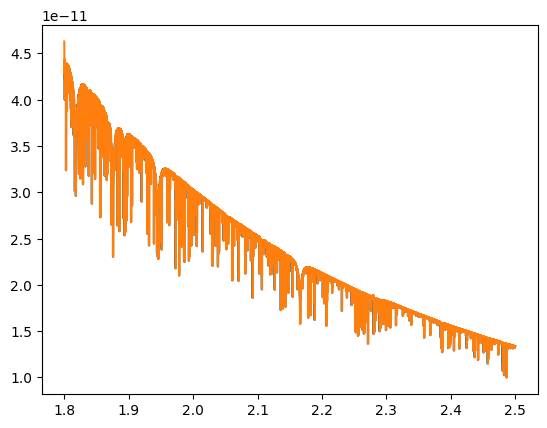

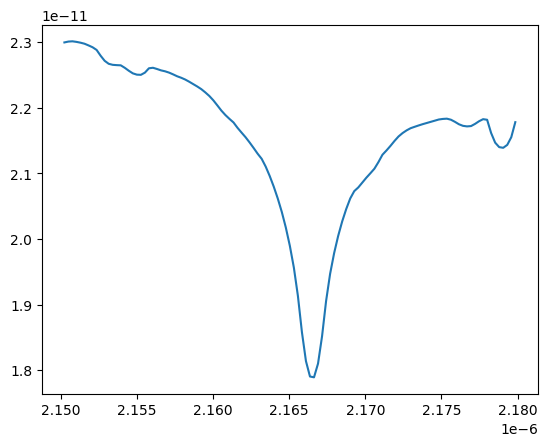

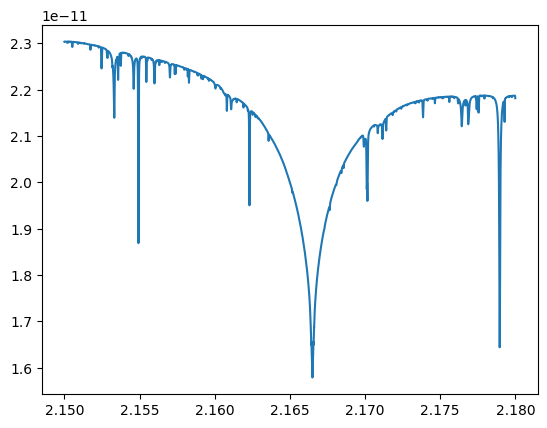

In [3]:
#Open the H5 file in read mode
filename = "/home/sauter/PhD/SIMTERFERE/Star_Spectra/lte08000-4.00-0.0.alpha=+1.2.PHOENIX-NewEra-ACES-COND-2023.HSR.h5"
f = h5py.File(filename, 'r')
flux = f['PHOENIX_SPECTRUM']['flux'][:]
wl = f['PHOENIX_SPECTRUM']['wl'][:]

wmin = 1.8
wmax = 2.5
wl_K = wl[(wl>wmin*1e4)&(wl<wmax*1e4)]*1e-4
flux_K = 10**flux[(wl>wmin*1e4)&(wl<wmax*1e4)]*10**-7*(1.732*6.957e+8/(19.44*3.086e+16))**2 #erg/cm²/cm to W/m²/µm, (radius/distance)²

plt.figure()
plt.plot(wl_K,flux_K)
flux_K = doppler_shift(wl_K, flux_K, v_rad=-55, c=299792.458)
plt.plot(wl_K,flux_K)
plt.show()

vsini = 120
flux_broadened = apply_rotational_broadening(wl_K, flux_K, vsini, epsilon=0.1)

f = "/home/sauter/PhD/beta Pic/astroreduced_stdpipe/astroreduced_stdpipe/SCI_BetaPicb_ONAXIS_2024-12-20T00:51:39_ASTROREDUCED.fits"
wave_sc = fits.open(f)[1].data["EFF_WAVE"]
wave_ft = fits.open(f)[2].data["EFF_WAVE"]

flux_sc = bin_spectrum(wl_K, flux_broadened, wave_sc*1e6)
flux_ft = bin_spectrum(wl_K, flux_broadened, wave_ft*1e6)

wmin = 2.15e-6
wmax=2.18e-6
plt.figure()
plt.plot(wave_sc[(wave_sc>wmin)&(wave_sc<wmax)],flux_sc[(wave_sc>wmin)&(wave_sc<wmax)])
plt.show()

plt.figure()
plt.plot(wl_K[(wl_K>wmin*1e6)&(wl_K<wmax*1e6)],flux_K[(wl_K>wmin*1e6)&(wl_K<wmax*1e6)])
plt.show()

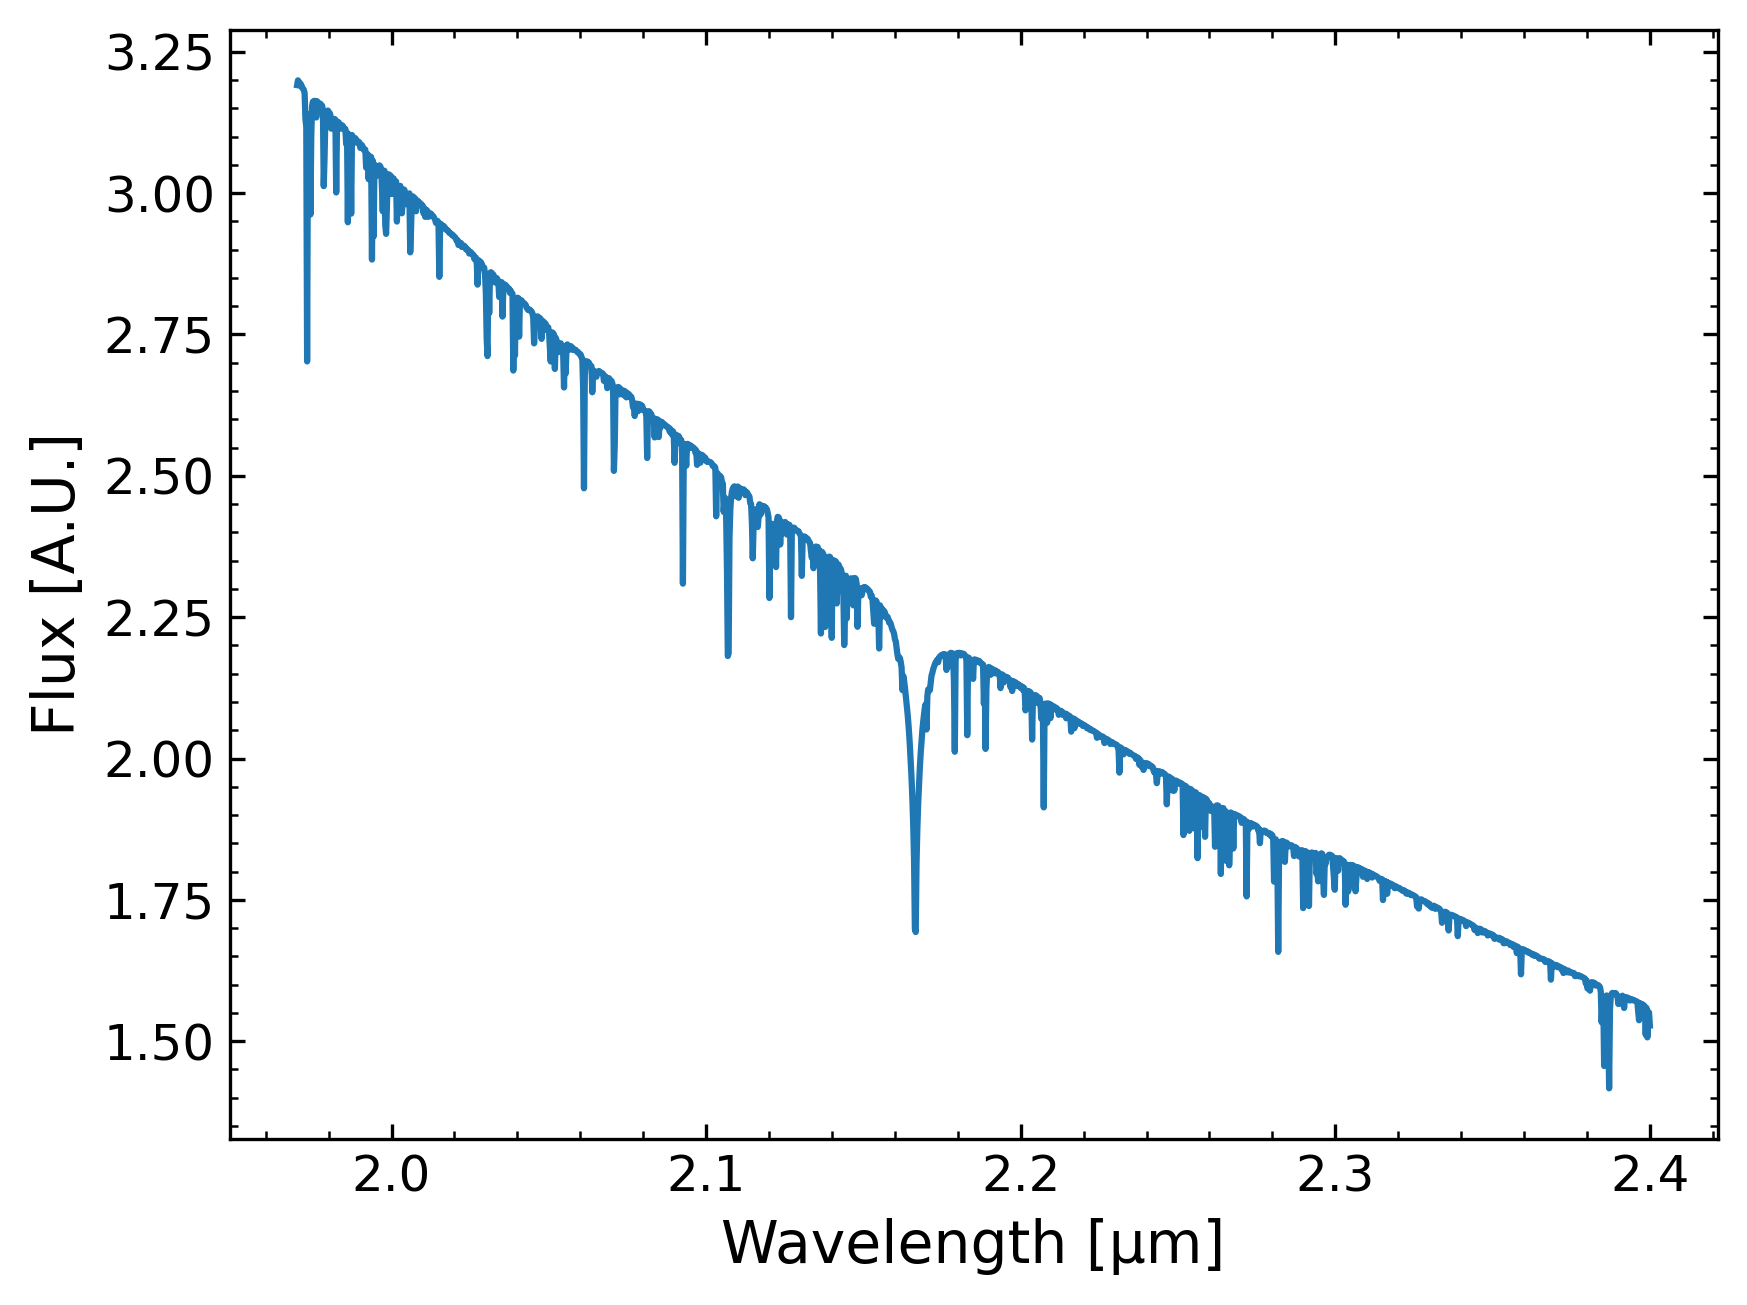

In [4]:
# Set number of bins
n_bins = 1628

# Step 4: bin flux and wave
if n_bins != 1628:
    binned_wave = np.linspace(np.min(wave_sc),np.max(wave_sc),n_bins)
else:
    binned_wave = np.copy(wave_sc)
binned_flux = bin_spectrum(wl_K, flux_K, binned_wave*1e6)

fig,ax = plt.subplots(dpi=300)
ax.plot(1e6*binned_wave,binned_flux*1e11)
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
ax.minorticks_on()
ax.set_xlabel('Wavelength [µm]',fontsize=14)
ax.set_ylabel('Flux [A.U.]',fontsize=14)
plt.show()

In [5]:
root = "/home/sauter/PhD/beta Pic/betaPic/betaPic/"

all_files = os.listdir(root)
files_star = []
for file in all_files:
    if "GRAVI.2024-12-20" in file and ".fits" in file:
        h = fits.open(root+file)[0].header
        #print(h["HIERARCH ESO ACQ FIBER SC1X"])
        if h["HIERARCH ESO DET2 SEQ1 DIT"] == 3 and "GRAVITY_PARALLEL_OBS" in h["ORIGFILE"]:
            files_star.append(file)
files_star.sort()
print('beta Pic')
for file in files_star:
    print(file)

root_sky = "/home/sauter/PhD/beta Pic/betaPic/betaPic/"

all_files = os.listdir(root_sky)
files_sky = []
for file in all_files:
    if ".fits" in file:
        h = fits.open(root_sky+file)[0].header
        if "SKY" in h["ORIGFILE"]:
            files_sky.append(file)
files_sky.sort()
print('SKY')
for file in files_sky:
    print(file)

beta Pic
GRAVI.2024-12-20T00:51:57.856.fits
GRAVI.2024-12-20T01:31:54.958.fits
GRAVI.2024-12-20T02:10:16.056.fits
GRAVI.2024-12-20T02:12:16.060.fits
GRAVI.2024-12-20T02:37:52.126.fits
GRAVI.2024-12-20T02:54:43.169.fits
GRAVI.2024-12-20T03:20:13.233.fits
GRAVI.2024-12-20T03:36:55.276.fits
GRAVI.2024-12-20T04:02:37.342.fits
GRAVI.2024-12-20T04:21:04.388.fits
GRAVI.2024-12-20T04:46:25.452.fits
GRAVI.2024-12-20T05:02:52.495.fits
GRAVI.2024-12-20T05:30:10.564.fits
GRAVI.2024-12-20T05:46:49.607.fits
GRAVI.2024-12-20T06:12:13.671.fits
GRAVI.2024-12-20T06:28:46.713.fits
GRAVI.2024-12-20T06:54:13.778.fits
GRAVI.2024-12-20T07:10:55.820.fits
SKY
GRAVI.2024-12-20T00:53:21.860.fits
GRAVI.2024-12-20T01:09:42.901.fits
GRAVI.2024-12-20T01:48:13.000.fits
GRAVI.2024-12-20T02:13:46.065.fits
GRAVI.2024-12-20T02:30:13.106.fits
GRAVI.2024-12-20T02:56:10.173.fits
GRAVI.2024-12-20T03:12:34.214.fits
GRAVI.2024-12-20T03:38:25.280.fits
GRAVI.2024-12-20T03:54:49.321.fits
GRAVI.2024-12-20T04:22:34.392.fits
GRAVI.2

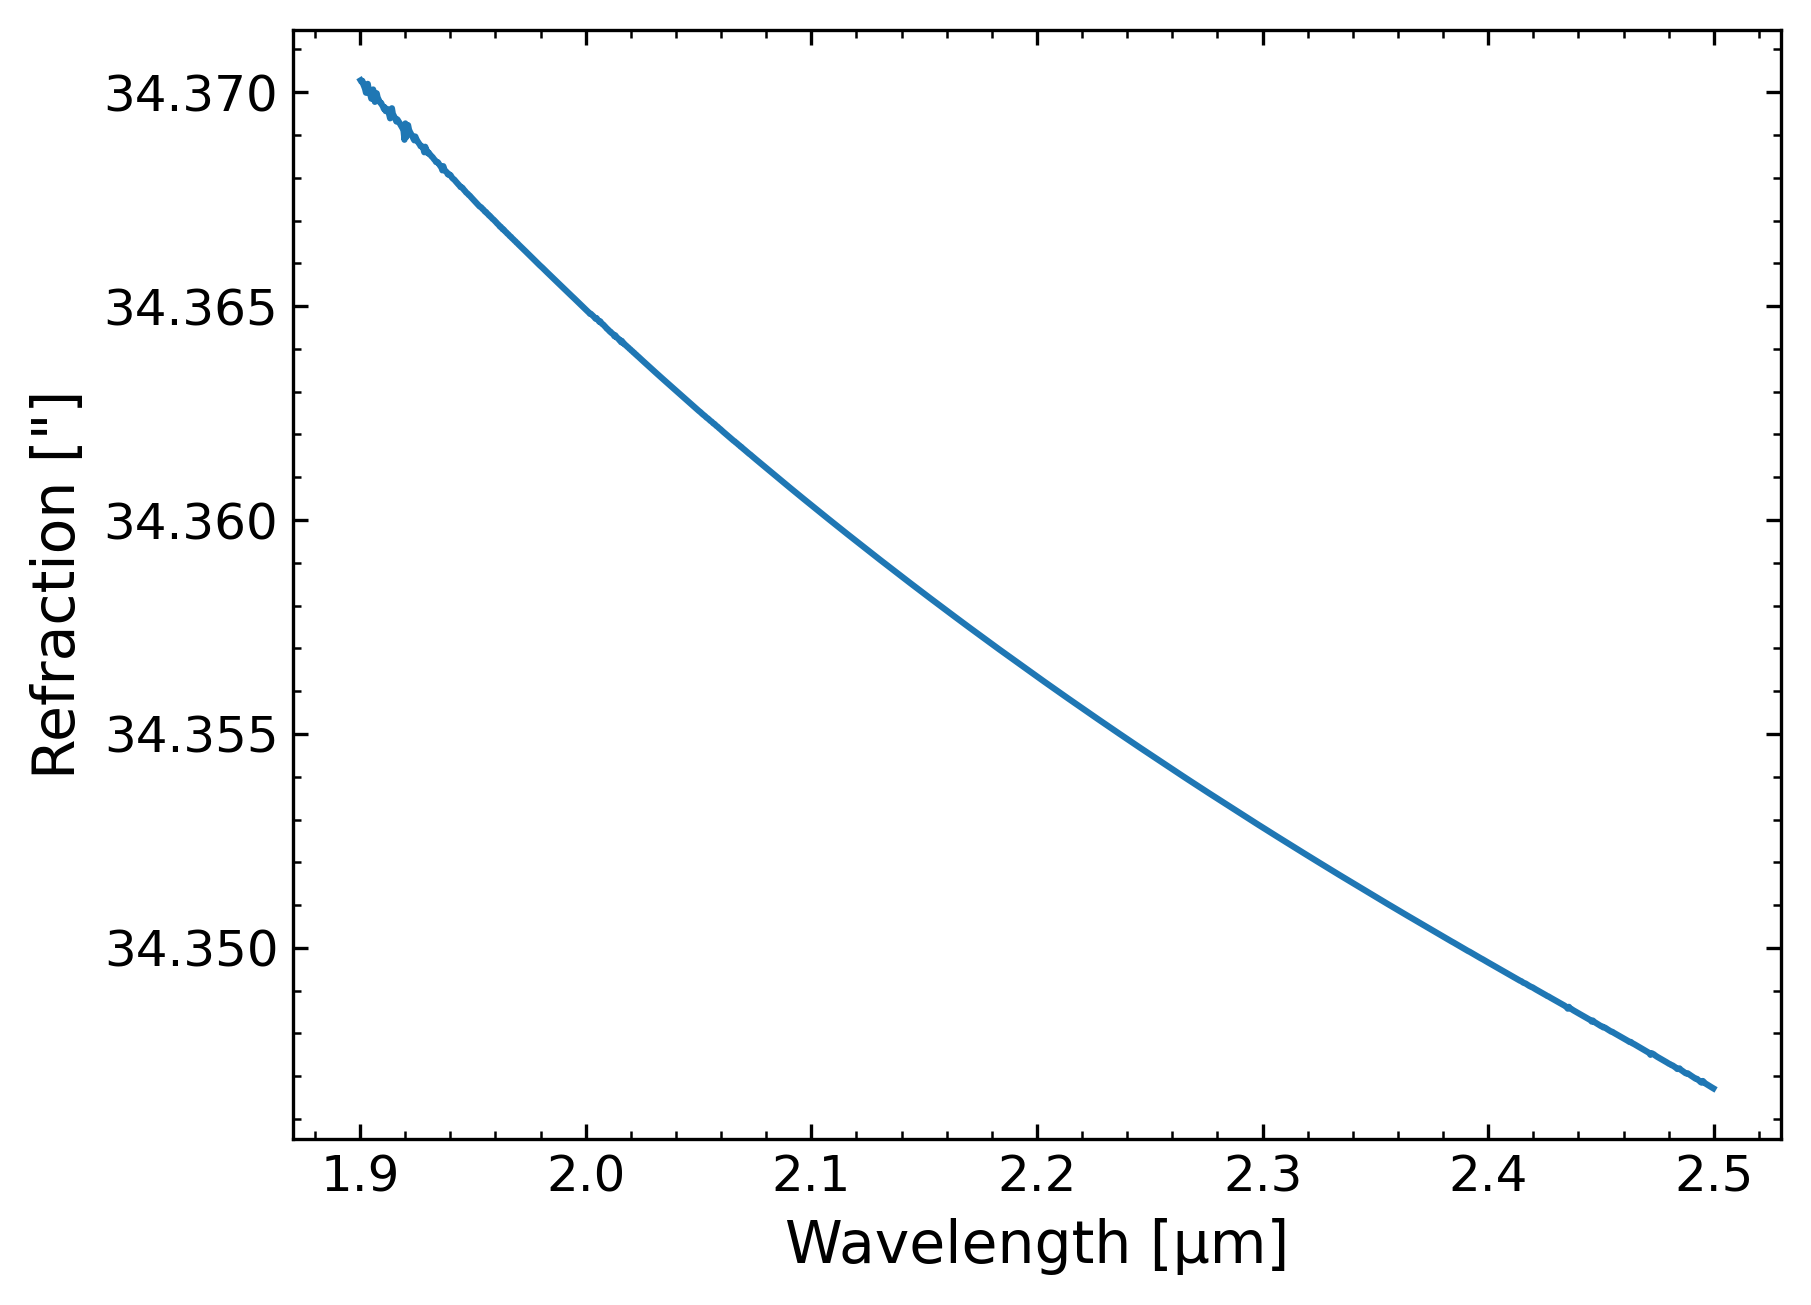

In [6]:
ref = np.loadtxt('/home/sauter/PhD/vlti_gravity_sim/data/grid/refraction_angle_PWV0.50mm_z39.715deg.txt',skiprows=11)
w = ref[:,0]
r = ref[:,1]
fig,ax = plt.subplots(dpi=300)
ax.plot(w[(w>1.9)&(w<2.5)],r[(w>1.9)&(w<2.5)])
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
ax.minorticks_on()
ax.set_xlabel('Wavelength [µm]',fontsize=14)
ax.set_ylabel('Refraction ["]',fontsize=14)
plt.show()

In [7]:
#"""
V2PM_ideal = np.array([
            [1,1,0,0,2,0,0,0,0,0],
            [1,1,0,0,2j,0,0,0,0,0],
            [1,1,0,0,-2,0,0,0,0,0],
            [1,1,0,0,-2j,0,0,0,0,0],

            [1,0,1,0,0,2,0,0,0,0],
            [1,0,1,0,0,2j,0,0,0,0],
            [1,0,1,0,0,-2,0,0,0,0],
            [1,0,1,0,0,-2j,0,0,0,0],

            [1,0,0,1,0,0,2,0,0,0],
            [1,0,0,1,0,0,2j,0,0,0],
            [1,0,0,1,0,0,-2,0,0,0],
            [1,0,0,1,0,0,-2j,0,0,0],

            [0,1,1,0,0,0,0,2,0,0],
            [0,1,1,0,0,0,0,2j,0,0],
            [0,1,1,0,0,0,0,-2,0,0],
            [0,1,1,0,0,0,0,-2j,0,0],

            [0,1,0,1,0,0,0,0,2,0],
            [0,1,0,1,0,0,0,0,2j,0],
            [0,1,0,1,0,0,0,0,-2,0],
            [0,1,0,1,0,0,0,0,0-2j,0],

            [0,0,1,1,0,0,0,0,0,2],
            [0,0,1,1,0,0,0,0,0,2j],
            [0,0,1,1,0,0,0,0,0,-2],
            [0,0,1,1,0,0,0,0,0,-2j],
                 ],dtype=np.complex128)
#"""

V2PM_ideal = np.repeat(V2PM_ideal[:, :, np.newaxis], 1628, axis=2)

In [8]:
file = "GRAVI.2024-12-20T10_49_26.376_p2vm.fits"

indices = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
data_v2pm = fits.open("/home/sauter/PhD/vlti_gravity_sim/data/V2PM/"+file)[4].data
#data_v2pm = fits.open("/home/sauter/PhD/beta Pic/P2VM_Calibration/GRAVI.2024-12-20T10_49_26.376_p2vm_calibrated.fits")[4].data
tm0 = data_v2pm["TRANSMISSION"]
coh0 = data_v2pm["COHERENCE"]
phase0 = data_v2pm["PHASE"]
cm0 = data_v2pm["C_MATRIX"]
wave = fits.open("/home/sauter/PhD/vlti_gravity_sim/data/V2PM/"+file)[3].data["EFF_WAVE"]
tm0 = np.abs(tm0)
#tm0 /= np.mean(tm0,axis=0)[None]
V2PM0 = np.empty((24,10,1628),dtype=np.complex128)
V2PM0[:,:4] = tm0
V2PM0[:,4:] = coh0*np.exp(1j*phase0)

V2PM = np.empty((24,10,1628),dtype=np.complex128)
V2PM[:4] = V2PM0[8:12]
V2PM[4:8] = V2PM0[20:]
V2PM[8:12] = V2PM0[4:8]
V2PM[12:16] = V2PM0[16:20]
V2PM[16:20] = V2PM0[:4]
V2PM[20:] = V2PM0[12:16]

#"""
cm = np.empty((24,6,1628))
cm[:4] = cm0[8:12]
cm[4:8] = cm0[20:]
cm[8:12] = cm0[4:8]
cm[12:16] = cm0[16:20]
cm[16:20] = cm0[:4]
cm[20:] = cm0[12:16]

tm = np.real(V2PM[:,:4])
coh = np.abs(V2PM[:,4:])
phase = np.angle(V2PM[:,4:])

# Prepare input slices
cm_gaus = gaussian_filter(cm,(0,0,10))
cm_cor = np.array([0.932317679135659,0.9464742088181359,1.052537356688332,0.9238538861837476,1.0377023240256658,1.1748933679443194])
args = [(i, np.mean(cm_cor[None,:]*cm_gaus[:,:,i],axis=0)) for i in range(1628)]

# Allocate result array
F_fit = np.empty((4, 1628))

# Run in parallel
with mp.Pool(processes=mp.cpu_count()-1) as pool:
    for i, result in pool.starmap(fit_flux, args):
        F_fit[:, i] = result

C_fit = np.empty((6,1628))
for i in range(6):
    C_fit[i] = np.sqrt(F_fit[indices[i][0]]*F_fit[indices[i][1]])

V2PM_SC = np.empty((24,10,1628),dtype=np.complex128)
V2PM_SC[:,:4] = F_fit[None]*tm
V2PM_SC[:,4:] = C_fit[None]*coh*np.exp(1j*phase)
#"""

In [9]:
fiber_sc_x = np.empty((18,4))
fiber_sc_y = np.empty((18,4))

fiber_ft_x = np.empty((18,4))
fiber_ft_y = np.empty((18,4))

for k in range(18):
    f = files_star[k][6:-5]
    file_path = '/home/sauter/PhD/beta Pic/betaPic/betaPic/GRAVI.'+f+'.fits'

    header = fits.open(file_path)[0].header

    # Load detector frame positions
    frame = np.array([
        [header.get(f"HIERARCH ESO DET1 FRAM{i+1} STRX", np.nan) for i in range(16)],
        [header.get(f"HIERARCH ESO DET1 FRAM{i+1} STRY", np.nan) for i in range(16)],
    ])

    x = np.arange(4) * 250
    xx, yy = np.meshgrid(x, x)
    frame0 = np.vstack([xx.ravel(), yy.ravel()])

    # Static reference pixel offsets
    reference_pos = [(128, 87), (368, 88), (620, 96), (877, 91)]

    corx = header.get("HIERARCH ESO ACQ ARD CORX", 0.0)
    cory = header.get("HIERARCH ESO ACQ ARD CORY", 0.0)

    for i in range(4):
        # SC fiber
        x_sc = header.get(f"HIERARCH ESO ACQ FIBER SC{i+1}X", np.nan)
        y_sc = header.get(f"HIERARCH ESO ACQ FIBER SC{i+1}Y", np.nan)
        # FT fiber
        x_ft = header.get(f"HIERARCH ESO ACQ FIBER FT{i+1}X", np.nan)
        y_ft = header.get(f"HIERARCH ESO ACQ FIBER FT{i+1}Y", np.nan)

        for j in range(16):
            if frame[0, j] <= x_sc <= frame[0, j] + 250 and frame[1, j] <= y_sc <= frame[1, j] + 250:
                fiber_sc_x[k, i] = x_sc - frame[0, j] + frame0[0, j] - reference_pos[i][0]
                fiber_sc_y[k, i] = y_sc - frame[1, j] + frame0[1, j] - reference_pos[i][1]
            if frame[0, j] <= x_ft <= frame[0, j] + 250 and frame[1, j] <= y_ft <= frame[1, j] + 250:
                fiber_ft_x[k, i] = x_ft - frame[0, j] + frame0[0, j] - reference_pos[i][0]
                fiber_ft_y[k, i] = y_ft - frame[1, j] + frame0[1, j] - reference_pos[i][1]

In [11]:
fold = ['10','01','-10','0-1','11','-1-1','1-1','-11']
dx = [1,0,-1,0,1,-1,1,-1]
dy = [0,1,0,-1,1,-1,-1,1]
amp = 0.3

for j in range(1):
   for i in range(18):
      f = files_star[i][6:-5]
      f_sky = files_sky[i][6:-5]
      print(f,f_sky)
      file_path = '/home/sauter/PhD/beta Pic/betaPic/betaPic/GRAVI.'+f+'.fits'
      sky_path = '/home/sauter/PhD/beta Pic/betaPic/betaPic/GRAVI.'+f_sky+'.fits'
      wavefront_path = '/home/sauter/PhD/SIMTERFERE/Wavefronts/'+f+'/'
      wave_sc_bin = binned_wave*1e6
      flux_sc_bin = binned_flux
      sim = simulation.Simulation(file_path,sky_path,wavefront_path,wave_sc=wave_sc_bin,wave_ft=wave_ft*1e6,flux_sc=flux_sc_bin,flux_ft=flux_ft,lam_eff=2.1795308730394645)
      #sim.get_wavefronts()

      #"""
      path = '/home/sauter/PhD/SIMTERFERE/Visibility_Simulation/'+f
      #path = '/home/sauter/PhD/SIMTERFERE/fiber_offsets/'+fold[j]+'/'
      #path = '/home/sauter/PhD/SIMTERFERE/Visibility_Simulation_Offset_Tel/'+f
      
      sc_offsets = np.empty(8)
      sc_offsets[::2] = 0.
      sc_offsets[1::2] = 0.
      sim.simulate_visibilities(
         path=path,
         V2PM_SC=V2PM_SC,
         V2PM_SC_calib=V2PM_SC,
         wave_V2PM_SC=wave*1e6,
         V2PM_FT=V2PM_ideal,
         V2PM_FT_calib=V2PM_ideal,
         wave_V2PM_FT=wave*1e6,
         num_opd=100,
         scale_opd=1.,
         scale_wavefront_errors=1,
         scale_refraction=1.,
         SNR_V2PM_calib=None,
         n_phases_calib=10,
         phase_calibartion_err=0,
         SNR_SC=None,
         SNR_FT=None,
         nboot=1,
         theta=0.736,
         track_fiber=True,
         sc_offsets = sc_offsets
         )
      #"""

2024-12-20T00:51:57.856 2024-12-20T00:53:21.860

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
29.15user 1.85system 0:31.07elapsed 99%CPU (0avgtext+0avgdata 8020maxresident)k
0inputs+1868040outputs (0major+1102minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
32.03user 2.29system 0:34.61elapsed 99%CPU (0avgtext+0avgdata 7996maxresident)k
0inputs+1867928outputs (0major+1098minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.97user 1.58system 0:30.60elapsed 99%CPU (0avgtext+0avgdata 7912maxresident)k
4560inputs+1868072outputs (16major+1087minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
34.57user 2.20system 0:37.07elapsed 99%CPU (0avgtext+0avgdata 7596maxresident)k
63672inputs+1868064outputs (36major+1076minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.35user 1.78system 0:30.17elapsed 99%CPU (0avgtext+0avgdata 7632maxresident)k
78696inputs+1868024outputs (36major+1074minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.91user 1.79system 0:30.74elapsed 99%CPU (0avgtext+0avgdata 7860maxresident)k
48inputs+1918976outputs (0major+1098minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
26.10user 1.55system 0:27.68elapsed 99%CPU (0avgtext+0avgdata 7972maxresident)k
24inputs+1867936outputs (0major+1103minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
26.86user 1.60system 0:28.48elapsed 99%CPU (0avgtext+0avgdata 7724maxresident)k
0inputs+1873048outputs (0major+1096minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
29.28user 1.80system 0:31.15elapsed 99%CPU (0avgtext+0avgdata 7664maxresident)k
71240inputs+1873080outputs (36major+1077minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
29.33user 1.86system 0:31.24elapsed 99%CPU (0avgtext+0avgdata 7848maxresident)k
80528inputs+1873064outputs (35major+1077minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
33.40user 2.03system 0:35.49elapsed 99%CPU (0avgtext+0avgdata 7820maxresident)k
80312inputs+1873056outputs (35major+1078minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
27.97user 1.73system 0:29.75elapsed 99%CPU (0avgtext+0avgdata 7816maxresident)k
80568inputs+1870632outputs (35major+1079minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
31.22user 1.93system 0:33.17elapsed 99%CPU (0avgtext+0avgdata 7540maxresident)k
80568inputs+1875720outputs (35major+1074minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.99user 1.86system 0:30.88elapsed 99%CPU (0avgtext+0avgdata 7920maxresident)k
80568inputs+1880576outputs (35major+1080minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
30.10user 1.64system 0:31.78elapsed 99%CPU (0avgtext+0avgdata 7636maxresident)k
80632inputs+1875656outputs (35major+1075minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
25.28user 1.47system 0:26.80elapsed 99%CPU (0avgtext+0avgdata 7632maxresident)k
80568inputs+1875688outputs (35major+1076minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
29.41user 1.62system 0:31.08elapsed 99%CPU (0avgtext+0avgdata 7792maxresident)k
80312inputs+1921480outputs (35major+1080minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
24.95user 1.43system 0:26.43elapsed 99%CPU (0avgtext+0avgdata 7808maxresident)k
80312inputs+1873088outputs (35major+1079minor)pagefaults 0swaps


Simulate visibilities for 16 integrations at 1628 SC wavelength bins with each 100 OPDs, by interpolating 39 acquisition images!
Calibrate V2PM...


/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site

Simulate frame 1/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 2/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 3/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 4/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 5/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 6/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 7/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 8/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 9/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 10/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 11/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 12/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 13/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 14/16
Get FT visibilities...
Get SC visibilities...
Simulate frame 15/16
Get FT visibilities...
Get SC visibilities...
Simu